In [1]:
import os, sys

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors

sns.set(style="whitegrid")

from sklearn.utils.extmath import row_norms
from sklearn.metrics.pairwise import _euclidean_distances
from tqdm.auto import tqdm

project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

from yace.run_worker import JobInfo

In [2]:
def get_performance_results(working_dir):
    distortions_rand = pd.read_feather(working_dir/"distortions-random-solutions.feather")
    distortions_conv = pd.read_feather(working_dir/"distortions-convex-solutions.feather")
    
    df1 = distortions_rand.agg(
        rand_distortion_mean=("distortion", np.mean),
        rand_distortion_std=("distortion", np.std),
        rand_distortion_min=("distortion", np.min),
        rand_distortion_max=("distortion", np.max),
    )

    df2 = distortions_conv.agg(
        conv_distortion_mean=("distortion", np.mean),
        conv_distortion_std=("distortion", np.std),
        conv_distortion_min=("distortion", np.min),
        conv_distortion_max=("distortion", np.max),
    )

    performance_results = pd.concat([df1, df2]).T.to_dict(orient="records")[0]
    return performance_results

def get_results(file_paths):
    raw_data = []
    for index, job_info_path in enumerate(file_paths):
        job_info = JobInfo.load_json(job_info_path)
        experiment_type = job_info.command_params["experiment-type"]
        working_dir = job_info_path.parent
        if len(list(working_dir.glob("*.*"))) == 0:
            continue
        perf_results = get_performance_results(working_dir=working_dir)
        duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
        raw_data.append({
            "k": job_info.experiment_params["k"],
            "epsilon": job_info.experiment_params["epsilon"],
            "algorithm": job_info.experiment_params["algorithm_name"],
            "running_time": duration_secs,
            **perf_results,
        })
    df_data = pd.DataFrame(raw_data)
    return df_data

def format_coreset_exp(coreset_exp):
    k_val = f"k^{{{coreset_exp}}}" if coreset_exp > 1 else "k"
    return f"$T = {k_val} / 10 \\epsilon^2$"

def get_raw_results(file_paths):
    data_frames = []
    with tqdm(total=len(file_paths)) as pbar:
        for index, job_info_path in enumerate(file_paths):
            job_info = JobInfo.load_json(job_info_path)
            experiment_type = job_info.command_params["experiment-type"]
            working_dir = job_info_path.parent
            duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
            if not (working_dir/"distortions-random-solutions.feather").exists():
                continue
            if not (working_dir/"distortions-convex-solutions.feather").exists():
                continue
            df_perf_data = pd.concat([
                pd.read_feather(working_dir/"distortions-random-solutions.feather"),
                pd.read_feather(working_dir/"distortions-convex-solutions.feather")
            ])
            experiment_id = working_dir.name
            if experiment_id.startswith("2022"):
                experiment_id = experiment_id[0:19]
            else:
                experiment_id = "-".join(experiment_id.split("-")[0:2])
            df_perf_data["experiment_id"] = experiment_id
            df_perf_data["experiment_name"] = working_dir.parent.name
            df_perf_data["experiment_type"] = experiment_type
            df_perf_data["running_time_secs"] = duration_secs
            df_perf_data["job_info_path"] = job_info_path
            
            for param, val in job_info.experiment_params.items():
                df_perf_data[f"{param}"] = val
            data_frames.append(df_perf_data)
            pbar.update()
    df_data = pd.concat(data_frames)
    algo_name_map = {"sensitivity-sampling": "Sensitivity Sampling", "uniform-sampling": "Uniform Sampling"}
    df_data["algorithm_name"] = df_data["algorithm_name"].apply(lambda val: algo_name_map[val])
    df_data["coreset_size_formatted"] = df_data["coreset_exp"].apply(format_coreset_exp)
    return df_data

def add_combined_mean_std(df: pd.DataFrame, attr: str):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        return f"{mean:0.4f} ({std:0.5f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)

def add_combined_median_iqr(df: pd.DataFrame, attr: str):
    def combiner(row) -> str:
        mean = row[f"{attr}_median"]
        std =  row[f"{attr}_iqr"]
        return f"{mean:0.4f} ({std:0.5f})"
    df[f"{attr}_median_iqr"] = df.apply(lambda x: combiner(x), axis=1)

In [3]:
job_info_paths  = []
job_info_paths += list(Path("../data/experiments-skadi/simple/epsilon_0_20/").glob("**/job-info.json"))
job_info_paths += list(Path("../data/experiments-skadi/simple/epsilon_0_10/").glob("**/job-info.json"))
job_info_paths += list(Path("../data/experiments-skadi/simple/epsilon_0_05/").glob("**/job-info.json"))
job_info_paths += list(Path("../data/experiments-skadi/simple/epsilon_0_01/").glob("**/job-info.json"))
print(f"Number of job files: {len(job_info_paths)}")

Number of job files: 9277


In [4]:
df_raw_results = get_raw_results(job_info_paths)
df_raw_results["k_formatted"] = "$k$=" + df_raw_results["k"].astype(str)
print(f"Number of results: {df_raw_results.shape[0]}")

  0%|          | 0/9277 [00:00<?, ?it/s]

Number of results: 927700


In [5]:
# Count number of experiments by data set
df_raw_results.groupby(["experiment_name"])[["experiment_id"]].nunique().rename(columns={"experiment_id": "n_experiments"})

,n_experiments
experiment_name,
epsilon_0_01,10
epsilon_0_05,100
epsilon_0_10,100
epsilon_0_20,100


In [6]:
colors = sns.color_palette("colorblind")
# algorithms = np.sort(df_raw_results.algorithm.unique())[::-1]
algorithms = ['Sensitivity Sampling', 'Uniform Sampling']
algorithm_colors = {algo: colors[i] for i, algo in enumerate(algorithms)}

In [7]:
pre_f1 = df_raw_results["algorithm_name"].isin(["Uniform Sampling", "Sensitivity Sampling"])
pre_f2 = df_raw_results.solution_type == "convex"
df_prefiltered = df_raw_results[pre_f1 & pre_f2]

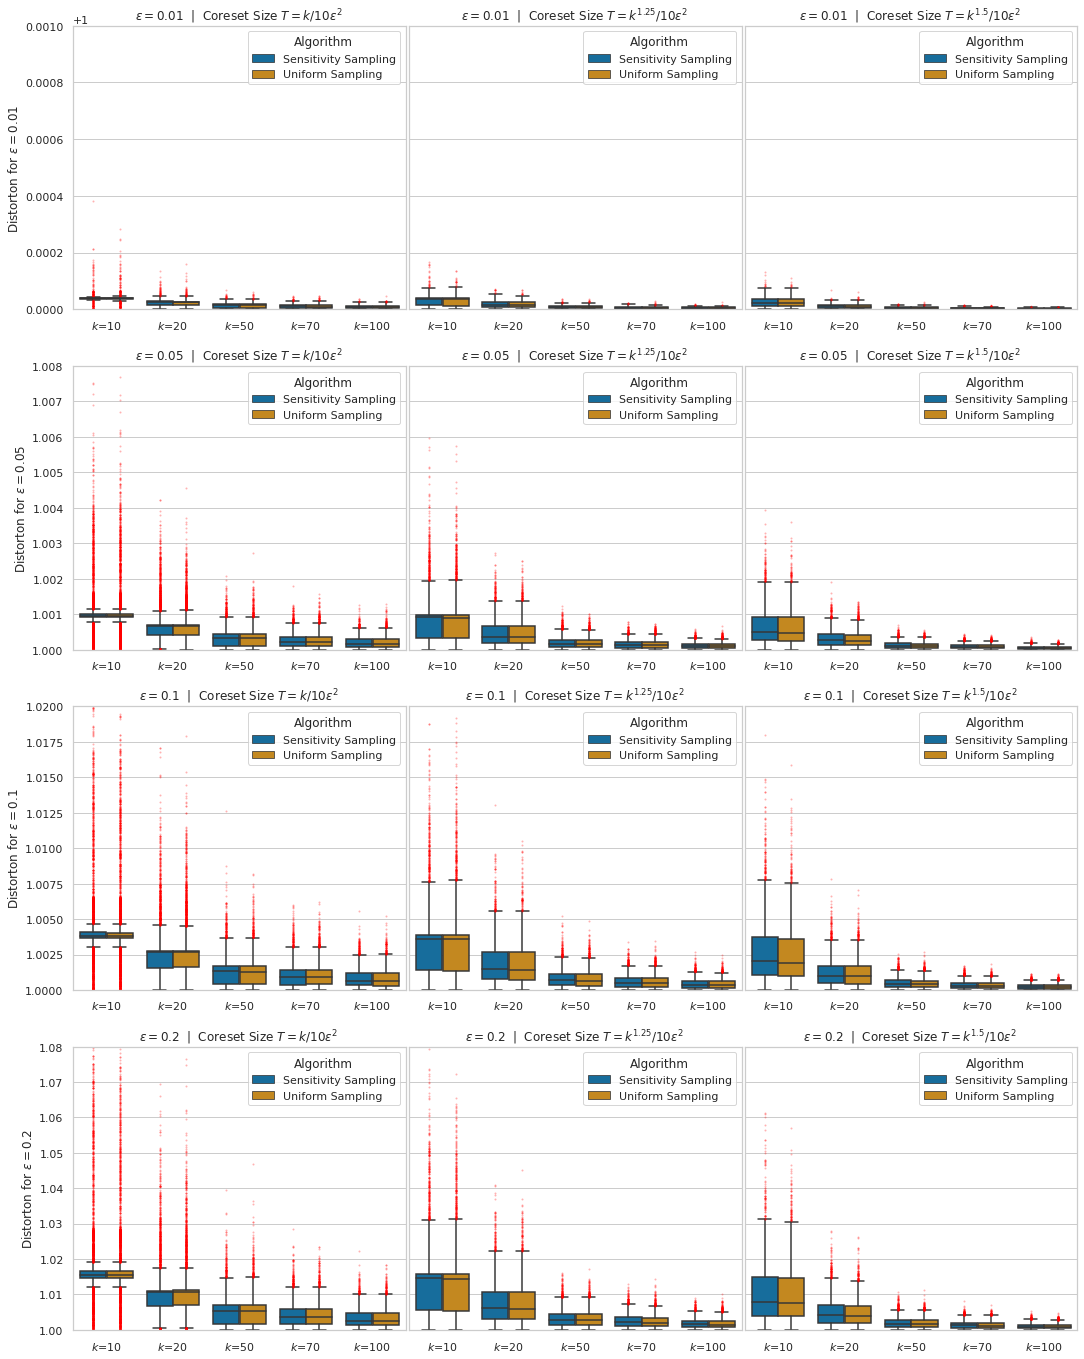

In [8]:
coreset_sizes = np.sort(df_prefiltered["coreset_size_formatted"].unique())
epsilons = np.sort(df_prefiltered["epsilon"].unique())
n_rows = len(epsilons)
n_cols = len(coreset_sizes)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=False, figsize=(18, n_rows*6))

outlier_points_props = dict(
    markerfacecolor='None',
    markersize=1,
    marker='o',
    markeredgecolor=plt_colors.colorConverter.to_rgba('red', alpha=.3),
)

for i, epsilon in enumerate(epsilons):
    for j, coreset_size_fmt in enumerate(coreset_sizes):
        ax = axes[i, j] # axes[i,j]
        f1 = df_prefiltered["coreset_size_formatted"] == coreset_size_fmt
        f2 = df_prefiltered["epsilon"] == epsilon
        df_filtered = df_prefiltered[f1 & f2].copy()
        df_filtered.sort_values(by=["k", "algorithm_name"], inplace=True)
        sns.boxplot(
            data=df_filtered, x="k_formatted", y="distortion", hue="algorithm_name", palette=algorithm_colors,
            flierprops=outlier_points_props,
            ax=ax
        )
        ax.set_ylim({0.2: [0.9998, 1.08], 0.1: [1.0, 1.02], 0.05: [1.0, 1.008], 0.01: [1.0, 1.001]}[epsilon])
        ax.set_title(f"$\\epsilon={epsilon}$  |  Coreset Size {coreset_size_fmt} ")
        ax.set_ylabel(f"Distorton for $\\epsilon={epsilon}$")
        ax.set_xlabel("")
        if j > 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])
        if i == 0:
            ax.set_xlabel("")
        ax.legend(title="Algorithm")
fig.subplots_adjust(wspace=0.01)
fig.savefig(f"plots-boxplot-distortions-instance-1.pdf", bbox_inches="tight")

In [9]:
grouping_cols = ["coreset_exp", "k", "algorithm_name", "epsilon", "solution_type"]
aggregation_spec = dict(
    # distortion_mean=("distortion", np.mean),
    # distortion_std=("distortion", np.std),
    distortion_median=("distortion", np.median),
    distortion_iqr=("distortion", sp.stats.iqr),
    n_solutions=("distortion", "count")
)
df_grouped = df_prefiltered.groupby(grouping_cols).agg(**aggregation_spec).reset_index()
# add_combined_mean_std(df=df_grouped, attr="distortion")
add_combined_median_iqr(df=df_grouped, attr="distortion")
df_grouped

,coreset_exp,k,algorithm_name,epsilon,solution_type,distortion_median,distortion_iqr,n_solutions,distortion_median_iqr
0,1.0,10,Sensitivity Sampling,0.01,convex,1.000038,0.000003,500,1.0000 (0.00000)
1,1.0,10,Sensitivity Sampling,0.05,convex,1.000957,0.000097,5000,1.0010 (0.00010)
2,1.0,10,Sensitivity Sampling,0.10,convex,1.003840,0.000404,5000,1.0038 (0.00040)
3,1.0,10,Sensitivity Sampling,0.20,convex,1.015485,0.001703,5000,1.0155 (0.00170)
4,1.0,10,Uniform Sampling,0.01,convex,1.000038,0.000004,500,1.0000 (0.00000)
...,...,...,...,...,...,...,...,...,...
115,1.5,100,Sensitivity Sampling,0.20,convex,1.000821,0.001008,5000,1.0008 (0.00101)
116,1.5,100,Uniform Sampling,0.01,convex,1.000002,0.000002,500,1.0000 (0.00000)
117,1.5,100,Uniform Sampling,0.05,convex,1.000048,0.000059,5000,1.0000 (0.00006)
118,1.5,100,Uniform Sampling,0.10,convex,1.000194,0.000233,5000,1.0002 (0.00023)


In [10]:
df_results_table = pd.pivot(
    data=df_grouped,
    index=["epsilon", "k", "coreset_exp"],
    columns=["algorithm_name"], 
    values="distortion_median_iqr"
)

In [11]:
df_results_table

algorithm_name          Sensitivity Sampling  Uniform Sampling
epsilon k   coreset_exp                                       
0.01    10  1.00            1.0000 (0.00000)  1.0000 (0.00000)
            1.25            1.0000 (0.00003)  1.0000 (0.00003)
            1.50            1.0000 (0.00003)  1.0000 (0.00003)
        20  1.00            1.0000 (0.00001)  1.0000 (0.00001)
            1.25            1.0000 (0.00002)  1.0000 (0.00002)
            1.50            1.0000 (0.00001)  1.0000 (0.00001)
        50  1.00            1.0000 (0.00001)  1.0000 (0.00001)
            1.25            1.0000 (0.00001)  1.0000 (0.00001)
            1.50            1.0000 (0.00000)  1.0000 (0.00000)
        70  1.00            1.0000 (0.00001)  1.0000 (0.00001)
            1.25            1.0000 (0.00001)  1.0000 (0.00001)
            1.50            1.0000 (0.00000)  1.0000 (0.00000)
        100 1.00            1.0000 (0.00001)  1.0000 (0.00001)
            1.25            1.0000 (0.00000)  1.0000 (0.00000)
            1.50            1.0000 (0.00000)  1.0000 (0.00000)
0.05    10  1.00            1.0010 (0.00010)  1.0010 (0.00010)
            1.25            1.0009 (0.00065)  1.0009 (0.00066)
            1.50            1.0005 (0.00066)  1.0005 (0.00067)
        20  1.00            1.0007 (0.00027)  1.0007 (0.00029)
            1.25            1.0004 (0.00048)  1.0004 (0.00048)
            1.50            1.0003 (0.00031)  1.0002 (0.00029)
        50  1.00            1.0003 (0.00034)  1.0003 (0.00033)
            1.25            1.0002 (0.00020)  1.0002 (0.00019)
            1.50            1.0001 (0.00012)  1.0001 (0.00012)
        70  1.00            1.0002 (0.00026)  1.0002 (0.00026)
            1.25            1.0001 (0.00015)  1.0001 (0.00015)
            1.50            1.0001 (0.00009)  1.0001 (0.00009)
        100 1.00            1.0002 (0.00021)  1.0002 (0.00022)
            1.25            1.0001 (0.00011)  1.0001 (0.00011)
            1.50            1.0001 (0.00006)  1.0000 (0.00006)
0.10    10  1.00            1.0038 (0.00040)  1.0038 (0.00041)
            1.25            1.0036 (0.00249)  1.0036 (0.00254)
            1.50            1.0021 (0.00267)  1.0019 (0.00262)
        20  1.00            1.0026 (0.00123)  1.0027 (0.00116)
            1.25            1.0015 (0.00192)  1.0014 (0.00195)
            1.50            1.0010 (0.00123)  1.0010 (0.00122)
        50  1.00            1.0013 (0.00130)  1.0013 (0.00132)
            1.25            1.0007 (0.00080)  1.0006 (0.00079)
            1.50            1.0004 (0.00050)  1.0004 (0.00048)
        70  1.00            1.0009 (0.00106)  1.0009 (0.00104)
            1.25            1.0005 (0.00059)  1.0005 (0.00060)
            1.50            1.0003 (0.00035)  1.0003 (0.00034)
        100 1.00            1.0006 (0.00086)  1.0006 (0.00088)
            1.25            1.0004 (0.00045)  1.0004 (0.00043)
            1.50            1.0002 (0.00024)  1.0002 (0.00023)
0.20    10  1.00            1.0155 (0.00170)  1.0155 (0.00173)
            1.25            1.0147 (0.01015)  1.0144 (0.01037)
            1.50            1.0079 (0.01091)  1.0077 (0.01067)
        20  1.00            1.0106 (0.00428)  1.0106 (0.00422)
            1.25            1.0060 (0.00770)  1.0058 (0.00769)
            1.50            1.0042 (0.00506)  1.0039 (0.00473)
        50  1.00            1.0053 (0.00526)  1.0052 (0.00527)
            1.25            1.0027 (0.00315)  1.0026 (0.00316)
            1.50            1.0016 (0.00194)  1.0015 (0.00189)
        70  1.00            1.0037 (0.00414)  1.0035 (0.00422)
            1.25            1.0020 (0.00251)  1.0020 (0.00230)
            1.50            1.0012 (0.00143)  1.0011 (0.00139)
        100 1.00            1.0025 (0.00348)  1.0025 (0.00349)
            1.25            1.0015 (0.00183)  1.0014 (0.00175)
            1.50            1.0008 (0.00101)  1.0008 (0.00094)

## Generating Distortion Table


In [12]:
epsilons = sorted(list(set([keys[0] for keys in df_results_table.index])))

for epsilon in epsilons:
    epsilon_slug = f"eps{epsilon}".replace(".", "_")
    
    output = df_results_table.loc[epsilon].to_latex()
    
    top_text = "\\multicolumn{4}{c}{\\textbf{Distortions on the Instance 1 ($\\epsilon=" + str(epsilon) +  "$)}} \\\\"
    
    output = output.replace(r"\begin{tabular}{llll}", r"\begin{longtable}{llll}" + f"\n{top_text}")
    
    #output = output.replace("algorithm\_name", " ")
    #output = output.replace("coreset\_exp", "Coreset Size")
    output = output.replace("    & algorithm\_name &", "$k$ & Coreset Size &")
    output = output.replace("k & coreset\_exp &                      &                   \\\\\n", "")
    
    
    output = output.replace("& 1.00 &", "& $k^{1.00} / 10 \\epsilon^2$ &")
    output = output.replace("& 1.25 &", "& $k^{1.25} / 10 \\epsilon^2$ &")
    output = output.replace("& 1.50 &", "& $k^{1.50} / 10 \\epsilon^2$ &")
    
    for n in [10, 20, 50, 70, 100]:
        output = output.replace(f"\\\\\n{n} ", f"\\\\\n\\midrule\n{n} ")
    
    label_text = f"\\label{{tab:inst1-{epsilon_slug}-distortions-median}}"
    n_runs = 10 if epsilon == 0.01 else 100
    caption_text = f"\caption{{Distortions of the evaluated algorithms on Instance 1 with $\\epsilon={epsilon}$. Reported are median values over {n_runs} runs, as well as IQR in paranthesis.}}"
    output = output.replace(r"\end{tabular}", f"{caption_text}\n{label_text}\n\\end{{longtable}}")
    print(output)

\begin{longtable}{llll}
\multicolumn{4}{c}{\textbf{Distortions on the Instance 1 ($\epsilon=0.01$)}} \\
\toprule
$k$ & Coreset Size & Sensitivity Sampling &  Uniform Sampling \\
\midrule
10  & $k^{1.00} / 10 \epsilon^2$ &     1.0000 (0.00000) &  1.0000 (0.00000) \\
    & $k^{1.25} / 10 \epsilon^2$ &     1.0000 (0.00003) &  1.0000 (0.00003) \\
    & $k^{1.50} / 10 \epsilon^2$ &     1.0000 (0.00003) &  1.0000 (0.00003) \\
\midrule
20  & $k^{1.00} / 10 \epsilon^2$ &     1.0000 (0.00001) &  1.0000 (0.00001) \\
    & $k^{1.25} / 10 \epsilon^2$ &     1.0000 (0.00002) &  1.0000 (0.00002) \\
    & $k^{1.50} / 10 \epsilon^2$ &     1.0000 (0.00001) &  1.0000 (0.00001) \\
\midrule
50  & $k^{1.00} / 10 \epsilon^2$ &     1.0000 (0.00001) &  1.0000 (0.00001) \\
    & $k^{1.25} / 10 \epsilon^2$ &     1.0000 (0.00001) &  1.0000 (0.00001) \\
    & $k^{1.50} / 10 \epsilon^2$ &     1.0000 (0.00000) &  1.0000 (0.00000) \\
\midrule
70  & $k^{1.00} / 10 \epsilon^2$ &     1.0000 (0.00001) &  1.0000 (0.00001)

/tmp/ipykernel_3358/3115556331.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  output = df_results_table.loc[epsilon].to_latex()
